# Calculating magnitudes with the LSST throughputs and rubin_sim packages.

This is a small demonstration of doing some very simple magnitude calculations.  Note that the throughput files are currently packages with rubin_sim, so the files in this directory are not necessary. See also tutorials at https://github.com/lsst/rubin_sim_notebooks.

---

To calculate expected LSST magnitudes, you first need a spectrum for your object of interest. Many potential spectra can be found in the LSST software package '[sims_seds_library](https://confluence.lsstcorp.org/display/SIM/SED+%28Spectral+Energy+Density%29+models+in+the+Catalogs+Simulation+Framework)', including Kurucz model spectra for main sequence stars, MLT spectra, white dwarf spectra and various galaxy spectral templates. 

For the purposes of this example, I will use a Kurucz model appropriate for our Sun (`kurucz_sun`, available in the throughputs/examples directory) and read it into the `Sed` class from rubin_sim. 

The format of this file (or any other spectra you want to use) is two columns, the first containing wavelength in nanometers and the second containing either F$_\lambda$ (in ergs/cm$^2$/s/nm) or F$_\nu$ (in Janksy). Our example `kurucz_sun` contains wavelength(nm) / F$_\lambda$(ergs/cm$^2$/s/nm).

In [1]:
# Import the necessary modules and classes.
import os
%matplotlib inline
import matplotlib.pyplot as plt

from rubin_sim.phot_utils import Bandpass,Sed

We read in the LSST throughput curves into Bandpass objects, as was done in the [LSST Throughput Curves notebook](http://nbviewer.ipython.org/github/LSST/throughputs/blob/master/examples/LSST%20Throughputs%20Curves.ipynb).

In [2]:
# Read the LSST throughput curves.
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}
# Get the throughputs directory using the 'throughputs' package env variables.
throughputsDir = os.getenv('LSST_THROUGHPUTS_BASELINE')
if throughputsDir is None:
    throughputsDir = '../baseline'
    
lsst = {}
for f in filterlist:
    lsst[f] = Bandpass()
    # Use os.path.join to join directory and filenames - it's safer.
    throughputsFile = os.path.join(throughputsDir, 'total_' + f + '.dat')
    lsst[f].read_throughput(throughputsFile)

And then we read the `kurucz_sun` spectrum into a Sed object. Because `kurucz_sun` contains $\lambda$ / F$_\lambda$, we use the Sed method `read_sed_flambda`.  If it had been a file containing $\lambda$ / F$_\nu$, we would use the `read_sed_fnu` method instead.

In [3]:
# Read the kurucz_sun spectrum.
sun = Sed()
sun.read_sed_flambda('kurucz_sun')

Let's make a plot of the SED ($\lambda F_\lambda$) and throughput curves vs. wavelength.

Text(0, 0.5, '$\\lambda F_\\lambda$ (ergs/cm$^2$/s)')

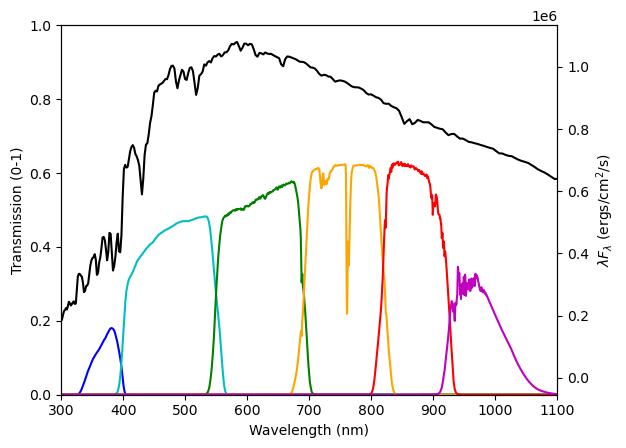

In [4]:
fig = plt.figure()
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
for f in filterlist:
    ax1.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f])
ax2.plot(sun.wavelen, sun.wavelen*sun.flambda, color='k')
plt.xlim(300, 1100)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Transmission (0-1)')
ax1.set_ylim(0, 1)
ax2.set_ylabel('$\lambda F_\lambda$ (ergs/cm$^2$/s)')

Pretty, but what are the magnitudes in the LSST system? After reading in the spectrum and the throughputs into Sed and Bandpass, in order to calculate a magnitude all you have to do is call `calc_mag`.

In [5]:
# Calculate expected AB magnitudes. 
mags = {}
for f in filterlist:
    mags[f] = sun.calc_mag(lsst[f])
    print('%s  %.2f' % (f, mags[f]))

u  -25.34
g  -26.50
r  -26.93
i  -27.04
z  -27.06
y  -27.06


Suppose you had a spectrum, but it didn't have an absolute scale. Or you wanted to scale it to have a given magnitude in a particular bandpass. For example, say we wanted to make our 'sun' spectrum have an r band magnitude of 20, then calculate the magnitudes in all bandpasses. We just use the `calc_flux_norm` and `multiply_flux_norm` methods.

In [6]:
# Scale spectrum and recalculate magnitudes.
# First, determine appropriate scaling factor to have r=20 in lsst[r] band.
fluxNorm = sun.calc_flux_norm(20.0, lsst['r'])
# Next, apply this scaling factor to the Sed object.
sun.multiply_flux_norm(fluxNorm)
# Now calculate magnitudes in all bands again.
for f in filterlist:
    mag = sun.calc_mag(lsst[f])
    print('%s  %.2f' %(f, mag))

u  21.59
g  20.44
r  20.00
i  19.89
z  19.88
y  19.87


Sed and Bandpass have some other handy features. For example, you could add dust extinction to your spectra (using the O'Donnel dust extinction law*). You can specify the amount of dust extinction using either A_v or E(B-V).
* Although we're using the O'Donnell dust extinction law, the method is called 'CCMab/CCMDust' for historical, code-evolution reasons. I expect this name will be updated to be more appropriate in the future.

u  22.35
g  21.02
r  20.44
i  20.22
z  20.13
y  20.08


(300.0, 1100.0)

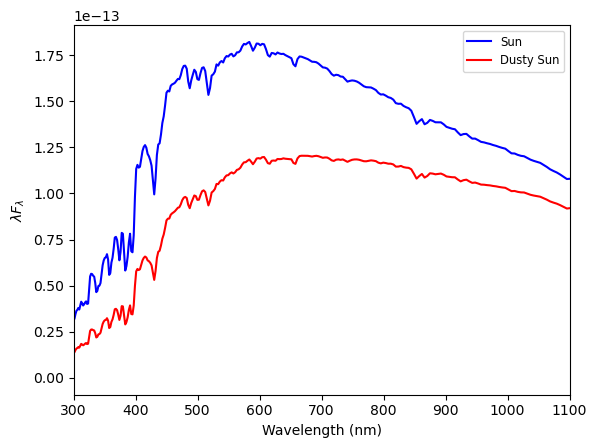

In [7]:
# Add dust extinction.
# First, calculate A_x and B_x coefficients.
a_x, b_x = sun.setup_ccm_ab()
# Next, actually add the dust extinction to a copy of the Sed.
dustySun = Sed(wavelen=sun.wavelen, flambda=sun.flambda)
A_v = 0.5
dustySun.add_ccm_dust(a_x, b_x, A_v)
# Calculate magnitudes with dust extinction.
for f in filterlist:
    mag = dustySun.calc_mag(lsst[f])
    print('%s  %.2f' %(f, mag))

# Let's just plot the two Seds.
fig = plt.figure()
plt.plot(sun.wavelen, sun.flambda*sun.wavelen, 'b-', label='Sun')
plt.plot(dustySun.wavelen, dustySun.flambda*dustySun.wavelen, 'r-', label='Dusty Sun')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$')
plt.legend(fancybox=True, fontsize='small')
plt.xlim(300, 1100)

You can also redshift a Sed, which probably is more useful for a galaxy, SN or quasar Sed than for a star. 

u  24.26
g  21.39
r  20.07
i  19.42
z  19.18
y  19.08


(300.0, 1100.0)

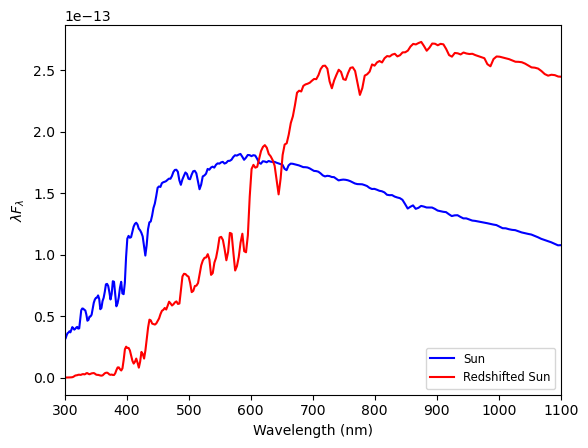

In [8]:
# Redshift a Sed.
redshiftedSun = Sed(wavelen=sun.wavelen, flambda=sun.flambda)
# Let's redshift our sun Sed to z=0.5
redshiftedSun.redshift_sed(0.5)
# Calculate magnitudes with redshift.
for f in filterlist:
    mag = redshiftedSun.calc_mag(lsst[f])
    print('%s  %.2f' %(f, mag))

# Let's just plot the two Seds.
plt.figure()
plt.plot(sun.wavelen, sun.flambda*sun.wavelen, 'b-', label='Sun')
plt.plot(redshiftedSun.wavelen, redshiftedSun.flambda*redshiftedSun.wavelen, 'r-', label='Redshifted Sun')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$')
plt.legend(loc='lower right', fancybox=True, fontsize='small')
plt.xlim(300, 1100)